In [281]:
%pip install -qU pandas matplotlib seaborn python-dotenv requests

Note: you may need to restart the kernel to use updated packages.


In [282]:
import pandas as pd

In [283]:
# .csv to pandas df
imdb_soundtracks = pd.read_csv("../data/sound_track_imdb_top_250_movie_tv_series.csv")
imdb_soundtracks

,Unnamed: 0,name,year,song_name,written_by,performed_by,composed_by,lyrics_by,written_performed_by,music_by,courtesy_of,conducted_by,libretto_by,under_license_from
0,0,The Shawshank Redemption,1994,If I Didn't Care,NaN,The Ink Spots,NaN,NaN,NaN,NaN,MCA Records,NaN,NaN,NaN
1,1,The Shawshank Redemption,1994,Duettino - Sull'aria,NaN,Edith Mathis (uncredited) and Gundula Janowitz...,Wolfgang Amadeus Mozart,NaN,NaN,NaN,NaN,Karl Böhm,Lorenzo da Ponte (uncredited),NaN
2,2,The Shawshank Redemption,1994,Put The Blame On Mame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,The Shawshank Redemption,1994,Lovesick Blues,NaN,Hank Williams,NaN,NaN,NaN,NaN,PolyGram Special Markets,NaN,NaN,NaN
4,4,The Shawshank Redemption,1994,Willie and The Hand Jive,NaN,NaN,NaN,NaN,NaN,NaN,Capitol Records,NaN,NaN,CEMA Special Markets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128,3128,"Love, Death & Robots",2019,It looks like we don't have any Soundtracks fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3129,3129,Foyle's War,2002,It looks like we don't have any Soundtracks fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3130,3130,Jesus of Nazareth,1977,It looks like we don't have any Soundtracks fo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3131,3131,Luther,2010,Paradise Circus,"Robert Del Naja, Grant Marshall, Hope Sandoval...",Massive Attack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unnamed: 0                 0
name                       0
year                       0
song_name                  0
written_by              1622
performed_by            1472
composed_by             2902
lyrics_by               2877
written_performed_by    3020
music_by                2651
courtesy_of             2069
conducted_by            3026
libretto_by             3122
under_license_from      2976
dtype: int64


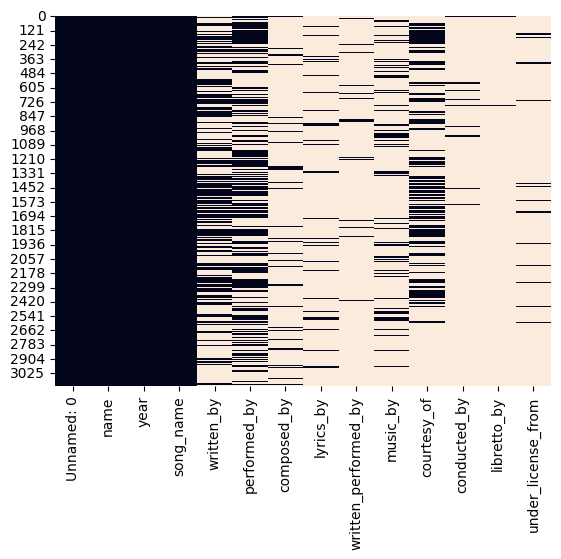

In [284]:
import seaborn as sns 
import matplotlib.pyplot as plt 

# Visualize null columns to see which fields are unnecessary
sns.heatmap(imdb_soundtracks.isnull(), cbar=False)
print(imdb_soundtracks.isna().sum())
plt.show()

In [285]:
# Drop unnecessary fields
imdb_soundtracks = imdb_soundtracks.drop(columns=['written_performed_by', 'conducted_by', 'libretto_by', 'under_license_from', 'Unnamed: 0'])

imdb_soundtracks.drop(imdb_soundtracks[imdb_soundtracks['song_name'] == "It looks like we don't have any Soundtracks for this title yet."].index, inplace = True)

# Convert to string to use for Spotify API search
imdb_soundtracks['performed_by'] = imdb_soundtracks['performed_by'].fillna("nan").astype(str)

In [286]:
imdb_soundtracks = imdb_soundtracks.reset_index(drop=True)

In [287]:
from dotenv import load_dotenv
import os
from requests import post, get
import base64
import json
from urllib.parse import quote

load_dotenv()

client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# print(client_id)
# print(client_secret)

# Token needed to search Spotify API
def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)

    json_result = json.loads(result.content)
    return json_result["access_token"]


In [288]:
def make_url(song_name, artist_name):
    url = "https://api.spotify.com/v1/search"
    song_name = song_name[:50]
    if(artist_name == "nan"):
        query = f'track:"{song_name}"'
    else:
        artist_name = artist_name[:50]
        query = f'track:"{song_name}" artist:"{artist_name}"'

    query = quote(query)
    query_url = f"{url}?q={query}&type=track&limit=1"
    return query_url

In [292]:
def song_data(json_result):
    title = json_result['name']
    artist = json_result['artists'][0]['name']
    artist_id = json_result['artists'][0]['id']
    album = json_result['album']['name']
    spotify_id = json_result['id']
    x = {
    "spotify_song": title,
    "spotify_artist": artist,
    "spotify_artist_id": artist_id,
    "spotify_album": album,
    "spotify_id": spotify_id
    }
    return json.dumps(x)


In [290]:
def search_track(token, song_name, artist_name):
    headers = {"Authorization": "Bearer " + token}

    query_url = make_url(song_name, artist_name)
    # print(query_url)
    result = get(query_url, headers=headers)
    # print(json.loads(result.content))
    json_result = json.loads(result.content)["tracks"]["items"]

    if len(json_result) == 0 and artist_name != "nan":
        print("Trying again with only song name...")
        # print(query_url)
        query_url = make_url(song_name, "nan")  
        result = get(query_url, headers=headers)
        json_result = json.loads(result.content)["tracks"]["items"]

    if len(json_result) == 0:
        return "No track found"
    
    data = song_data(json_result[0])
    print(data)
    return data

token = get_token()
# print(token)

In [ ]:
result = search_track(token, "Sign of the Times", "Harry Styles")
print(result)

In [ ]:
imdb_soundtracks.iat[0, 5]
result = search_track(token, imdb_soundtracks.iat[4, 3], imdb_soundtracks.iat[4, 5])
print(result)

In [294]:
# spotify_soundtrack_results = []

In [ ]:
# start = 0

# # Marking this out bc I don't want to accidently run it
# for index, row in imdb_soundtracks.iloc[start:].iterrows(): 
#     song_name = row['song_name']
#     artist_name = row['performed_by']
#     print(f'Index: {index}, Get {song_name} by {artist_name}')
    
#     data = search_track(token, song_name, artist_name)

#     spotify_soundtrack_results.append(data)

In [ ]:
# print(spotify_soundtrack_results)

In [296]:
import pickle

# with open('../data/spotify-soundtrack-results.pkl', 'wb') as f:
#     pickle.dump(spotify_soundtrack_results, f)

with open('../data/spotify-soundtrack-results.pkl', 'rb') as f:
    spotify_data = pickle.load(f)

In [ ]:
imdb_soundtracks

In [317]:
# 2964 last index
spotify_data[6]

'No track found'

In [ ]:
import numpy as np

spotify_soundtracks_df = pd.DataFrame(spotify_data)
spotify_soundtracks_df[0] = spotify_soundtracks_df[0].replace({'No track found': '{}', np.nan: '{}'})

spotify_soundtracks_df = spotify_soundtracks_df[0].apply(json.loads).apply(pd.Series)
spotify_soundtracks_df.head(10)

imdb_spotify_soundtracks = pd.concat([imdb_soundtracks, spotify_soundtracks_df], axis=1)
imdb_spotify_soundtracks = imdb_spotify_soundtracks.drop(columns = ['composed_by', 'lyrics_by', 'music_by', 'courtesy_of'])
imdb_spotify_soundtracks.dropna(subset = ['spotify_song', 'spotify_artist', 'spotify_id'], inplace=True)

In [372]:
imdb_spotify_soundtracks = imdb_spotify_soundtracks.reset_index(drop=True)
imdb_spotify_soundtracks.isna().sum()

name                    0
year                    0
song_name               0
written_by           1333
performed_by            0
spotify_song            0
spotify_artist          0
spotify_artist_id       0
spotify_album           0
spotify_id              0
dtype: int64

In [373]:
imdb_spotify_soundtracks.head(10)

,name,year,song_name,written_by,performed_by,spotify_song,spotify_artist,spotify_artist_id,spotify_album,spotify_id
0,The Shawshank Redemption,1994,If I Didn't Care,NaN,The Ink Spots,If I Didn't Care,The Ink Spots,5bOsFzuJ6QZMr86ezC4oXY,The Anthology,2jPgfwVXOKnUl2QLQsnIAT
1,The Shawshank Redemption,1994,Duettino - Sull'aria,NaN,Edith Mathis (uncredited) and Gundula Janowitz...,"The Marriage of Figaro / ""Duettino"" Sull 'Aria",Wolfgang Amadeus Mozart,4NJhFmfw43RLBLjQvxDuRS,The Shawshank Redemption,4CZWCG1KOEZPGdQqDL85VF
2,The Shawshank Redemption,1994,Put The Blame On Mame,NaN,nan,Put the Blame on Mame,Jazz At The Movies,0feC9MH5Mq7iiKxFab4cKQ,Kiss Kiss Bang Bang,34M8EsL4rqmzUCeX9PVKgM
3,The Shawshank Redemption,1994,Lovesick Blues,NaN,Hank Williams,Lovesick Blues,Hank Williams,1FClsNYBUoNFtGgzeG74dW,Moanin' The Blues (Expanded Edition),1x4iqHqbgf9oHsQJ6FGnCy
4,The Shawshank Redemption,1994,Willie and The Hand Jive,NaN,nan,Willie And The Hand Jive,Johnny Otis,5PGt6fQNjLKhYYeGLWKWcM,Ring A Ling,4BW5ZIAegQxpKtUyR5eLh6
5,The Shawshank Redemption,1994,A Mighty Fortress Is Our God,Martin Luther,Bob Gunton,A Mighty Fortress Is Our God,Chris Rice,0vD3f3r69jBB1bL6VWnGM2,Peace Like A River: The Hymns Project,7lmwDlkBDwPwMO75wHVbl2
6,The Godfather,1972,I Have But One Heart,NaN,Al Martino (uncredited),I Have But One Heart,Al Martino,7egNqIGRldMzifHoh8pib6,The Godfather,4rTozJf2UY14LNG6Q3E321
7,The Godfather,1972,Luna mezz' 'o mare,NaN,Morgana King (uncredited),Luna Mezz 'O Mare,Patrizio Buanne,14JwkiGRzeex4jLuDoWpQ5,Forever Begins Tonight,29mowJjsbQNQVgkGBt2NEI
8,The Godfather,1972,Manhattan Serenade,NaN,Tommy Dorsey & His Orchestra (uncredited),Manhattan Serenade,Tommy Dorsey,4WoGga7UeRcmjD4ufif4nG,The Incomparable Tommy Dorsey,6AsCaYsDYoyU2PEFbSLgpf
9,The Godfather,1972,Have Yourself a Merry Little Christmas,Hugh Martin and Ralph Blane,Al Martino (uncredited),Have Yourself A Merry Little Christmas - Remas...,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,A Jolly Christmas From Frank Sinatra,2FPfeYlrbSBR8PwCU0zaqq


In [374]:
def genre_data(json_result):
    artist = json_result['name']
    genres = json_result['genres']
    x = {
    "spotify_artist1": artist,
    "genres": genres
    }
    return json.dumps(x)

In [375]:
# Retrieve artists and genres

def search_genre(token, artist_id):
    headers = {"Authorization": "Bearer " + token}
    url = f"https://api.spotify.com/v1/artists/{artist_id}"

    # print(url)
    result = get(url, headers=headers)
    print(json.loads(result.content))
    json_result = json.loads(result.content)# ['artists']
    
    data = genre_data(json_result)
    print(data)
    return data

token = get_token()
# print(token)

In [381]:
spotify_artist_genres = []

In [ ]:
import time
start = 0

# Marking this out bc I don't want to accidently run it
for index, row in imdb_spotify_soundtracks.iloc[start:].iterrows(): 
    artist_name = row['spotify_artist']
    artist_id = row['spotify_artist_id']
    print(f'Index: {index}, Get {artist_name} genres with ID: {artist_id}')
    
    data = search_genre(token, artist_id)

    spotify_artist_genres.append(data)
    time.sleep(0.5)

In [383]:
# with open('../data/spotify-artist-genre-results.pkl', 'wb') as f:
#     pickle.dump(spotify_artist_genres, f)

with open('../data/spotify-artist-genre-results.pkl', 'rb') as f:
    spotify_artist_genres_data = pickle.load(f)

In [ ]:
spotify_artist_genres_df = pd.DataFrame(spotify_artist_genres_data)
spotify_artist_genres_df = spotify_artist_genres_df[0].apply(json.loads).apply(pd.Series)
spotify_artist_genres_df.head(10)

In [ ]:
imdb_spotify_soundtracks_genres = pd.concat([imdb_spotify_soundtracks, spotify_artist_genres_df], axis=1)

In [389]:
imdb_spotify_soundtracks_genres.head(10)

,name,year,song_name,written_by,performed_by,spotify_song,spotify_artist,spotify_artist_id,spotify_album,spotify_id,spotify_artist1,genres
0,The Shawshank Redemption,1994,If I Didn't Care,NaN,The Ink Spots,If I Didn't Care,The Ink Spots,5bOsFzuJ6QZMr86ezC4oXY,The Anthology,2jPgfwVXOKnUl2QLQsnIAT,The Ink Spots,[adult standards]
1,The Shawshank Redemption,1994,Duettino - Sull'aria,NaN,Edith Mathis (uncredited) and Gundula Janowitz...,"The Marriage of Figaro / ""Duettino"" Sull 'Aria",Wolfgang Amadeus Mozart,4NJhFmfw43RLBLjQvxDuRS,The Shawshank Redemption,4CZWCG1KOEZPGdQqDL85VF,Wolfgang Amadeus Mozart,"[classical, opera, requiem, classical piano, c..."
2,The Shawshank Redemption,1994,Put The Blame On Mame,NaN,nan,Put the Blame on Mame,Jazz At The Movies,0feC9MH5Mq7iiKxFab4cKQ,Kiss Kiss Bang Bang,34M8EsL4rqmzUCeX9PVKgM,Jazz At The Movies,[]
3,The Shawshank Redemption,1994,Lovesick Blues,NaN,Hank Williams,Lovesick Blues,Hank Williams,1FClsNYBUoNFtGgzeG74dW,Moanin' The Blues (Expanded Edition),1x4iqHqbgf9oHsQJ6FGnCy,Hank Williams,"[classic country, honky tonk, traditional coun..."
4,The Shawshank Redemption,1994,Willie and The Hand Jive,NaN,nan,Willie And The Hand Jive,Johnny Otis,5PGt6fQNjLKhYYeGLWKWcM,Ring A Ling,4BW5ZIAegQxpKtUyR5eLh6,Johnny Otis,"[doo-wop, rockabilly, jazz blues]"
5,The Shawshank Redemption,1994,A Mighty Fortress Is Our God,Martin Luther,Bob Gunton,A Mighty Fortress Is Our God,Chris Rice,0vD3f3r69jBB1bL6VWnGM2,Peace Like A River: The Hymns Project,7lmwDlkBDwPwMO75wHVbl2,Chris Rice,"[christian, ccm, worship]"
6,The Godfather,1972,I Have But One Heart,NaN,Al Martino (uncredited),I Have But One Heart,Al Martino,7egNqIGRldMzifHoh8pib6,The Godfather,4rTozJf2UY14LNG6Q3E321,Al Martino,"[adult standards, easy listening]"
7,The Godfather,1972,Luna mezz' 'o mare,NaN,Morgana King (uncredited),Luna Mezz 'O Mare,Patrizio Buanne,14JwkiGRzeex4jLuDoWpQ5,Forever Begins Tonight,29mowJjsbQNQVgkGBt2NEI,Patrizio Buanne,[schlager]
8,The Godfather,1972,Manhattan Serenade,NaN,Tommy Dorsey & His Orchestra (uncredited),Manhattan Serenade,Tommy Dorsey,4WoGga7UeRcmjD4ufif4nG,The Incomparable Tommy Dorsey,6AsCaYsDYoyU2PEFbSLgpf,Tommy Dorsey,"[big band, swing music, adult standards]"
9,The Godfather,1972,Have Yourself a Merry Little Christmas,Hugh Martin and Ralph Blane,Al Martino (uncredited),Have Yourself A Merry Little Christmas - Remas...,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,A Jolly Christmas From Frank Sinatra,2FPfeYlrbSBR8PwCU0zaqq,Frank Sinatra,"[christmas, big band, adult standards, swing m..."
